# Organism WRONG WRONG WRONG
In the simplest model, there is only a class for the **Organism**. Each organism reproduces asexually with the parameter that an individual's population $f(t)$ is governed by $f(t) = f(0)e^{st}$ where $s$ is a fitness parameter determined by an organism's individual fitness. Some individuals will acquire a beneficial mutation with probability $U_b$, increasing their fitness, whereas others may acquire a detrimental mutation with probability $U_d$. To implement this mechanistically, *while keeping population size constant*, we first convert the fitness $s$ to an expected number of offspring for each organism.

In [6]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt

class Population:
    def __init__(self, Ub, Ud, size):
        """
        Creates Population (see Organism specs)
        """
        self.Ub = Ub
        self.Ud = Ud
        self.gens = [[]]
        self.size = size
        
        for i in range(self.size):
            self.gens[0].append(Organism(np.random.random(), Ub, Ud, [len(self.gens)-1, i]))
            
    def __str__(self):
        return f'population with size {len(self.gens[-1])}, {len(self.gens)} generations, Ub {self.Ub}, Ud {self.Ud}'
            
    def reproduce(self):
        
        self.gens.append([])
        weights = [math.exp(org.s) for org in self.gens[-2]]
        
        for i in range(self.size):
            choice = random.choices(self.gens[-2], weights=weights)[0]
            self.gens[-1].append(choice.reproduce([len(self.gens)-1, i]))

class Organism:
    def __init__(self, s, Ub, Ud, index, parent=None):
        """
        Creates Organism object with fitness s, beneficial mutation rate Ub, detrimental mutation rate Ud, and
        a parent, which is either another Organism object or None if in the parent generation
        index = [gen, number in gen]
        """
        self.s = s
        self.Ub = Ub
        self.Ud = Ud
        self.index = index
        self.parent = parent
        self.children = []
    
    def __str__(self):
        return f'organism {self.index}'
        
    def reproduce(self, index):
        """
        reproduces and gives mutation accordingly
        adds resultant Organism to self.children
        returns resultant Organism
        """
        
        if np.random.random() < self.Ub:
            self.s += self.s * 0.01
        
        if np.random.random() < self.Ud:
            self.s -= self.s * 0.01
        
        child = Organism(self.s, self.Ub, self.Ud, index, parent=self)
        self.children.append(child)
        
        return child

In [7]:
from pprint import pprint
import time

start_time = time.time()

bacteria = Population(10**(-4), 10**(-3), 10**1)

num_gens = 3
for i in range(num_gens):
    bacteria.reproduce()

print(bacteria)
print(np.asarray(bacteria.gens).shape)
# for gen in bacteria.gens:
#     pprint([str(org) for org in gen])
    
print("--- %s seconds ---" % (time.time() - start_time))

population with size 10, 4 generations, Ub 0.0001, Ud 0.001
(4, 10)
--- 0.0010118484497070312 seconds ---


ancestor organism [0, 0], immediate children [<__main__.Organism object at 0x1052600d0>]


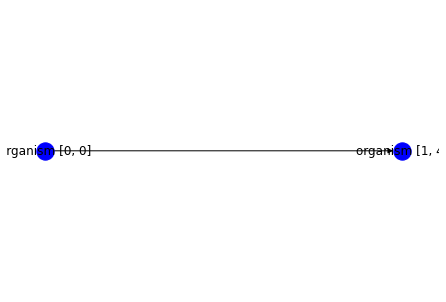

ancestor organism [0, 1], immediate children [<__main__.Organism object at 0x117ea4b20>, <__main__.Organism object at 0x117e1f370>]


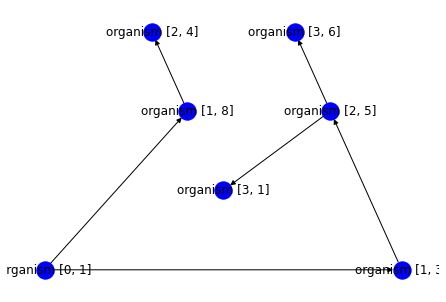

ancestor organism [0, 2], immediate children []


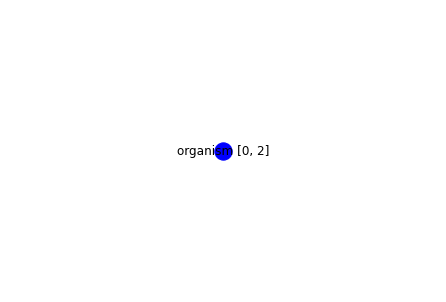

ancestor organism [0, 3], immediate children []


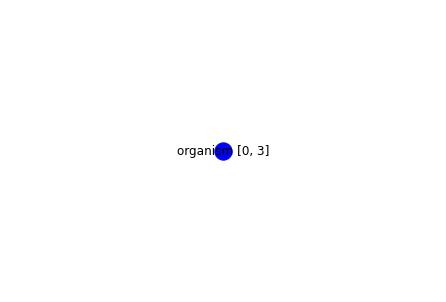

ancestor organism [0, 4], immediate children []


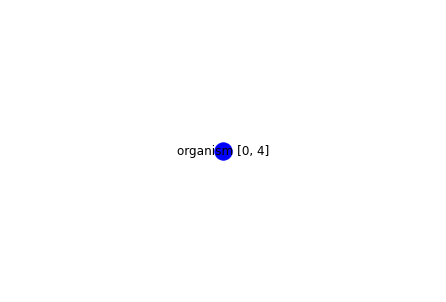

ancestor organism [0, 5], immediate children []


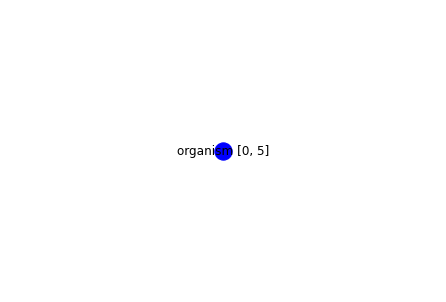

ancestor organism [0, 6], immediate children [<__main__.Organism object at 0x117f64d90>, <__main__.Organism object at 0x117e1f190>]


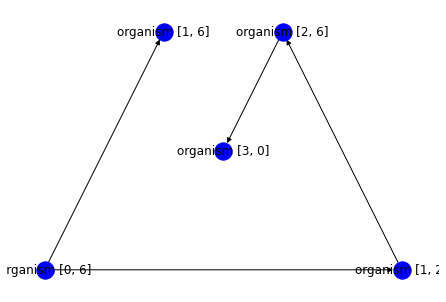

ancestor organism [0, 7], immediate children [<__main__.Organism object at 0x117f64a60>, <__main__.Organism object at 0x117ea4f10>, <__main__.Organism object at 0x117ea4220>]


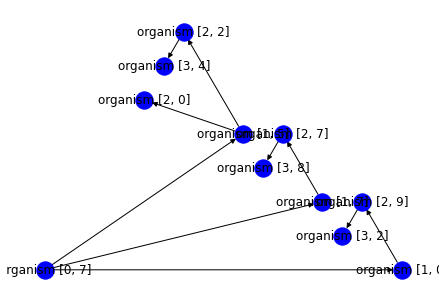

ancestor organism [0, 8], immediate children [<__main__.Organism object at 0x117ea4fd0>]


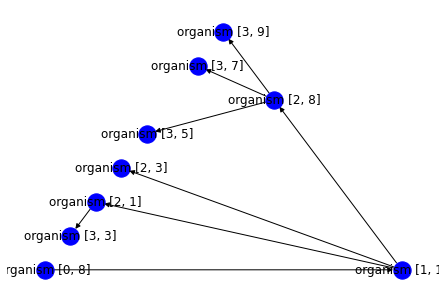

ancestor organism [0, 9], immediate children [<__main__.Organism object at 0x1052abdc0>]


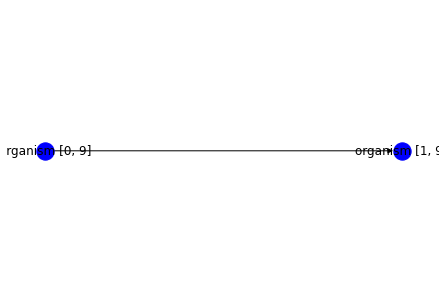

--- 36.475175857543945 seconds ---


<Figure size 432x288 with 0 Axes>

In [9]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def add_children_to_graph(ancestor, graph):
    if len(ancestor.children) == 0:
        return
    else:
        for child in ancestor.children:
            graph.add_edge(ancestor, child)
            add_children_to_graph(child, graph)



for ancestor in bacteria.gens[0]:
    G = nx.DiGraph()
    
    print(f'ancestor {ancestor}, immediate children {ancestor.children}')

    G.add_node(ancestor)

    add_children_to_graph(ancestor, G)

    nx.draw_planar(G, with_labels=True, node_color = ['blue']) #TODO pos
    plt.show(); plt.figure(); plt.clf()

print("--- %s seconds ---" % (time.time() - start_time))